# How can we control the increasing number of accidents in New York?

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction

**Business Context.** The city of New York has seen a rise in the number of accidents on the roads in the city. They would like to know if the number of accidents have increased in the last few weeks. For all the reported accidents, they have collected details for each accident and have been maintaining records for the past year and a half (from January 2018 to August 2019). 

The city has contracted you to build visualizations that would help them identify patterns in accidents, which would help them take preventive actions to reduce the number of accidents in the future. They have certain parameters like borough, time of day, reason for accident, etc. Which they care about and which they would like to get specific information on.

**Business Problem.** Your task is to format the given data and provide visualizations that would answer the specific questions the client has, which are mentioned below.

**Analytical Context.** You are given a CSV file containing details about each accident like date, time, location of the accident, reason for the accident, types of vehicles involved, injury and death count, etc. The delimiter in the given CSV file is `;` instead of the default `,`. You will be performing the following tasks on the data:

1. Extract data from Wikipedia
2. Read, transform, and prepare data for visualization
3. Perform analytics and construct visualizations of the data to identify patterns in the dataset
        
The client has a specific set of questions they would like to get answers to. You will need to provide visualizations to accompany these:

1. How have the number of accidents fluctuated over the past year and a half? Have they increased over the time?
2. For any particular day, during which hours are accidents most likely to occur?
3. Are there more accidents on weekdays than weekends?
4. What are the accidents count-to-area ratio per borough? Which boroughs have disproportionately large numbers of accidents for their size?
5. For each borough, during which hours are accidents most likely to occur?
6. What are the top 5 causes of accidents in the city? 
7. What types of vehicles are most involved in accidents per borough?
8. What types of vehicles are most involved in deaths?

## Fetch borough data from Wikipedia

The client has requested analysis of the accidents-to-area ratio for boroughs. You will need to fetch the area of each borough from the Wikipedia page: https://en.wikipedia.org/wiki/Boroughs_of_New_York_City.

Since we are fetching this resource from an external page, you should instead fetch the HTML document and store the results locally in a JSON file, so that you can parse it later when you need it. Create a folder named `data` and store the file inside it.

Insert **answer** below:

In [2]:
# Code here
html = requests.get('https://en.wikipedia.org/wiki/Boroughs_of_New_York_City')
with open('data/boroughs.html', 'w') as f:
    f.write(html.text)

For later usage, let's store the borough data into a JSON file in the already created `data` folder:

In [3]:
# Code here
with open('data/boroughs.html', "r") as f:
    html_content = f.read()
    
soup = BeautifulSoup(html_content, 'html.parser')
brows = soup.findAll('tr', attrs={'style':'background:f9f9f9;'})
barea_km = {}
for brow in brows:
    btds = brow.findAll('td')
    b = btds[0].text.rstrip().upper()
    if b == 'THE BRONX':
        b = 'BRONX'
    barea_km[b] = btds[6].text.rstrip()

with open('data/boroughs_area_km.json', 'w') as f:
    json.dump(barea_km, f)    
    
barea_km

{'BRONX': '109.04',
 'BROOKLYN': '183.42',
 'MANHATTAN': '59.13',
 'QUEENS': '281.09',
 'STATEN ISLAND': '151.18'}

## Overview of the data

Now that we've stored the borough data in a JSON file, we can re-open it and use it whenever we wish. We can use the `read_json()` function in `pandas` to do that:

In [4]:
# Code here
barea = pd.read_json('data/boroughs_area_km.json', lines=True)
barea['BROOKLYN'][0]
barea

,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,109.04,183.42,59.13,281.09,151.18


Let's go through the columns present in the dataframe:

In [5]:
accidents_df = pd.read_csv('accidents.csv', sep=';')
accidents_df.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/26/2018,12:12,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,...,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN
1,09/25/2018,16:30,BROOKLYN,11236.0,40.636005,-73.912510,FLATLANDS AVENUE,1,0,0,...,NaN,NaN,NaN,NaN,3987962,Sedan,NaN,NaN,NaN,NaN
2,08/22/2019,19:30,QUEENS,11101.0,40.755490,-73.939530,NaN,0,0,0,...,NaN,NaN,NaN,NaN,4193132,Sedan,NaN,NaN,NaN,NaN
3,09/23/2018,13:10,QUEENS,11367.0,NaN,NaN,MAIN STREET,0,0,1,...,Unspecified,NaN,NaN,NaN,3985962,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,08/20/2019,22:40,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,...,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN


In [6]:
df.columns

NameError: name 'df' is not defined

We have the following columns

1. **Borough**: The borough in which the accident occured
2. **COLLISION_ID**: A unique identifier for this collision
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Reasons for the accident
4. **CROSS STREET NAME**: Nearest cross street to the place of accidents
5. **DATE**: Date of the accident
6. **TIME**: Time of accident
7. **DATETIME**: The column we previously created with the combination of date and time
8. **LATITUDE**: Latitude of the accident
9. **LONGITUDE**: Longitude of the accident
10. **NUMBER OF (CYCLIST, MOTORIST, PEDESTRIANS) INJURED**: Category wise injury
11. **NUMBER OF (CYCLIST, MOTORIST, PEDESTRIANS) KILLED**: Category wise death
12. **ON STREET NAME**: Street where the accident occured
13. **TOTAL INJURED**: Total injury from the accident
14. **TOTAL KILLED**: Total casualties in the accident
15. **VEHICLE TYPE CODE (1, 2, 3, 4, 5)**: Types of vehicles involved in the accident
16. **ZIP CODE**: zip code of the accident location

Let's go ahead and answer each of the client's questions.

## Answering the client's questions

### Part 1: Accidents over time

Group the available data on a monthly basis and generate a line plot of accidents over time. Has the number of accidents increased over the past year and a half?

Insert **answer** below:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

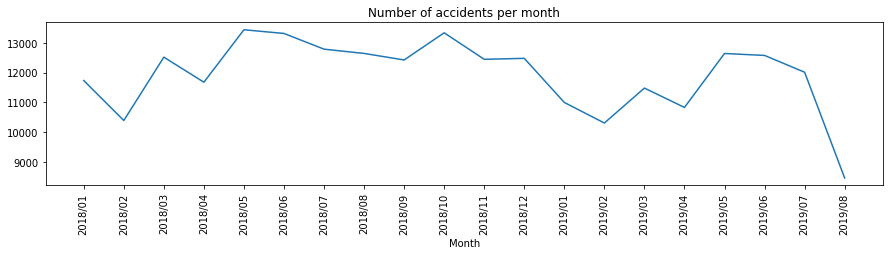

In [7]:
# Code here
accidents_df['MONTH'] = accidents_df.apply(lambda row: row['DATE'][6:]+'/'+row['DATE'][:2], axis=1)
acc_by_month_df = accidents_df.groupby('MONTH')['DATE'].count()

fig, ax = plt.subplots(figsize=(15,3))
ax.plot(acc_by_month_df)
plt.title('Number of accidents per month')
plt.xlabel('Month');
plt.xticks(rotation=90)

**Type your answer to the question in this cell**

*Has the number of accidents increased over the past year and a half?*

No, the curve is rather constant. In fact, the last month, i.e. 2019/08 the number accidents decreased. However, it seems the data is incompleted, given that there is no data from 08/25/2019

### Part 2: Accident hotspots in a day

How does the number of accidents vary throughout a single day? Create a new column `HOUR` based on the data from the `DATETIME` column, then plot a bar graph of the distribution per hour throughout the day.

Insert **answer** below:

Text(0.5, 0, 'Hour')

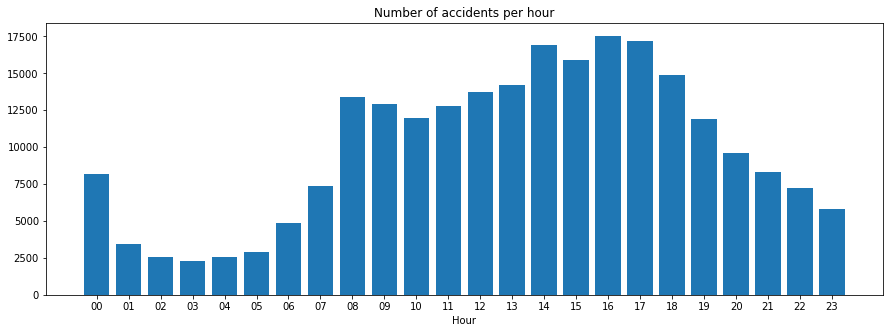

In [8]:
# Code here
accidents_df.head()
accidents_df['HOUR'] = accidents_df.apply(lambda row: "0"+row['TIME'][:1] if ":" in row['TIME'][:2] else row['TIME'][:2], axis=1)
hours = accidents_df.groupby('HOUR')['HOUR'].count()

fig, ax = plt.subplots(figsize=(15,5))
plt.bar(hours.index, hours)
plt.title('Number of accidents per hour')
plt.xlabel('Hour')

**Type your answer to the question in this cell**

There is an initial peak at 8, then the number of accidents starts increasing until 14. From there, the number of accidents remains in its highest peak during the day until 18, where it starts decreasing.

### Part 3: Accidents by weekday

How does the number of accidents vary throughout a single week? Plot a bar graph based on the accidents count by day of the week.

Insert **answer** below:

Text(0.5, 0, 'Weekday')

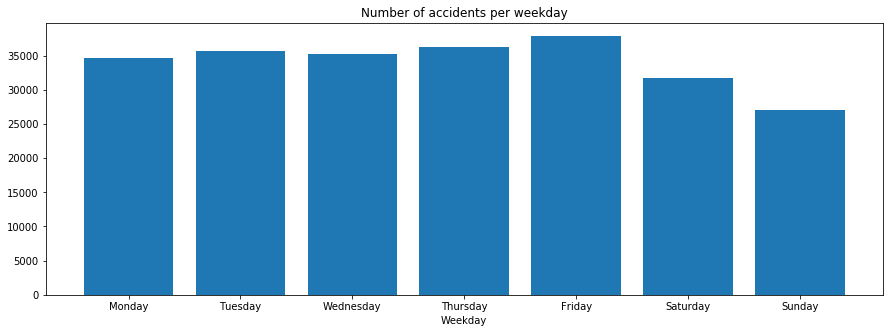

In [9]:
# Code here
import datetime

accidents_df['WEEKDAY'] = accidents_df['DATE'].apply(lambda x: datetime.datetime.strptime(str(x), "%m/%d/%Y").strftime("%A"))
accidents_df.head()
days = accidents_df.groupby('WEEKDAY')['WEEKDAY'].count()
days_ordered = days.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

fig, ax = plt.subplots(figsize=(15,5))
plt.bar(days_ordered.index, days_ordered)
plt.title('Number of accidents per weekday')
plt.xlabel('Weekday')

**Type your answer to the question in this cell**

The number of accidents increase slightly from Monday to Friday, where Fridays present the highest number of accidents. Then on Saturday and Sunday decrease where Sundays has the lowest number of accidents

### Part 4: Borough analysis

Plot a bar graph of the total number of accidents in each borough, as well as one of the accidents per square kilometer per borough. What can you conclude?

Insert **answer** below:

,NACCIDENTS,NACCPERSKM
BOROUGH,,
BRONX,37709,345.83
BROOKLYN,76253,415.73
MANHATTAN,48749,824.44
QUEENS,67120,238.78
STATEN ISLAND,8691,57.49


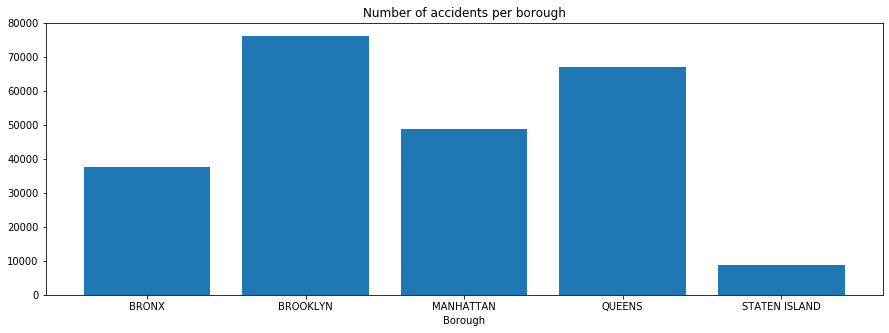

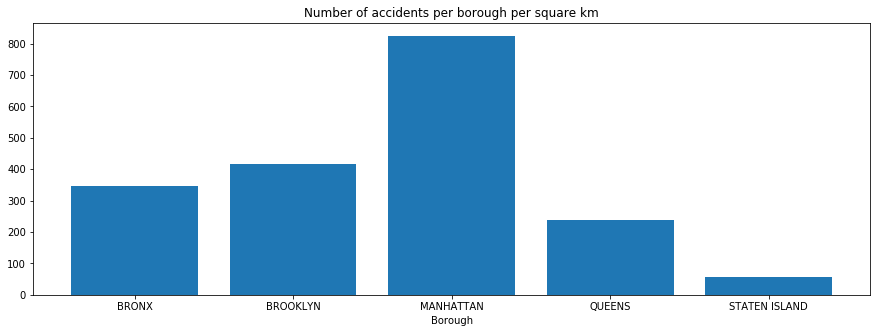

In [10]:
# Code here
borough = accidents_df.groupby('BOROUGH')['DATE'].count()

borough_df = pd.DataFrame(index=borough.index, columns=['NACCIDENTS'], data=borough.values)
borough_df['NACCPERSKM'] = borough_df.apply(lambda row: round(row['NACCIDENTS']/barea[row.name][0], 2), axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(borough_df.index, borough_df['NACCIDENTS'])
plt.title('Number of accidents per borough')
plt.xlabel('Borough')

fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(borough_df.index, borough_df['NACCPERSKM'])
plt.title('Number of accidents per borough per square km')
plt.xlabel('Borough')

borough_df.head()

**Type your answer to the question in this cell**

Although Brooklyn has the highest number of accidents in total, Manhattan has the highest number of accidents per square kilometer which is twice the number of accidents of Brooklyn per squere km. 

In [ ]:
# Hint: update keys in borough data


# Hint: Since there are differences in the text used in the data and Wikipedia data, let's update it

# Done above while loading borough area info from Wikipedia




We have now got the keys to match in the dictionary and the dataframe. The difference in case can be handled by making the mapping action case-insensitive. This can be done by either converting the dictionary keys to uppercase, or the dataframe data to lowercase.

Let's do that and plot `accidents_per_sq_km`, which is the accidents-to-area ratio:

In [ ]:
# Code here

# Done above

**Type your answer to the question in this cell**

### Part 5: Borough hourly analysis

Which hours have the most accidents for each borough? Plot a bar graph for each borough showing the number of accidents for each hour of the day.

Insert **answer** below:

Text(0.5, 0, 'Hour')

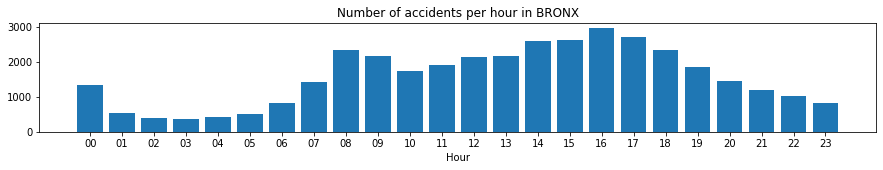

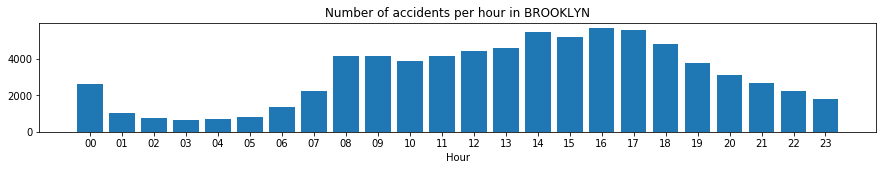

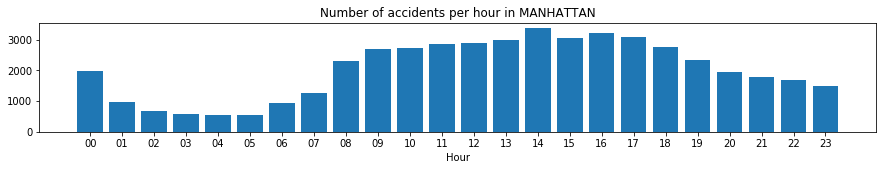

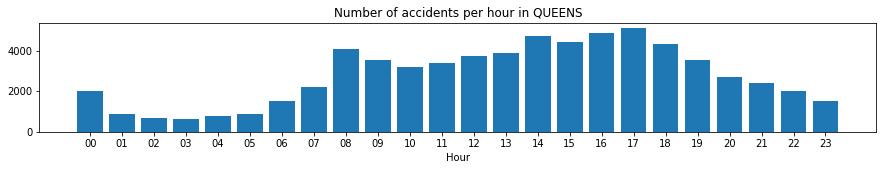

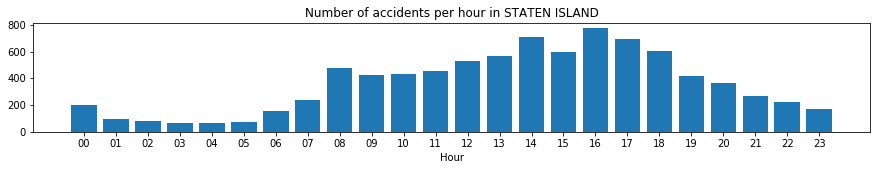

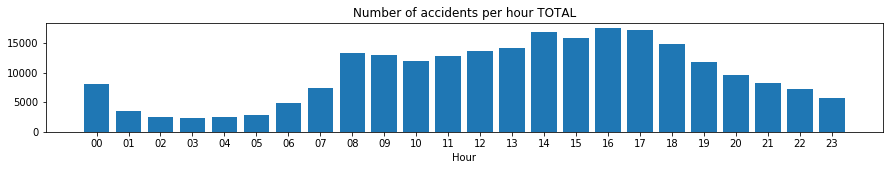

In [11]:
# Code here
borough_names = list(barea.columns)

# plot per borough
for b in borough_names:
    bhours_df = accidents_df[accidents_df['BOROUGH'] == b]
    bhours = bhours_df.groupby('HOUR')['HOUR'].count()
    fig, ax = plt.subplots(figsize=(15,2))
    plt.bar(bhours.index, bhours)
    plt.title('Number of accidents per hour in '+b)
    plt.xlabel('Hour')

# plot total  
fig, ax = plt.subplots(figsize=(15,2))
plt.bar(hours.index, hours)
plt.title('Number of accidents per hour TOTAL')
plt.xlabel('Hour')

**Is the number of accidents higher at different times in different boroughs? Should we concentrate at different times for each borough?**

**Type your answer to the question in this cell**

**Is the number of accidents higher at different times in different boroughs?**
Yes, in Mannhatan the highest is at 14. In Queens, the highest is at 17. In the remaining boroughs is at 16. 

**Should we concentrate at different times for each borough?**
I would say, the difference is not significant, and we should concentrate in general between 14 and 17.

### Part 6: Cause of accidents

What factors cause the most accidents?

Insert **answer** below:

In [12]:
# Code here
contributing_factors = ['CONTRIBUTING FACTOR VEHICLE 1',
                        'CONTRIBUTING FACTOR VEHICLE 2',
                        'CONTRIBUTING FACTOR VEHICLE 3',
                        'CONTRIBUTING FACTOR VEHICLE 4',
                        'CONTRIBUTING FACTOR VEHICLE 5']

list_of_cofa = []

for i in contributing_factors:
    list_of_cofa.append(accidents_df[i])

pd.concat(list_of_cofa).value_counts()

Unspecified                                              240164
Driver Inattention/Distraction                            72203
Failure to Yield Right-of-Way                             20413
Following Too Closely                                     17909
Backing Unsafely                                          15068
Passing Too Closely                                       13378
Passing or Lane Usage Improper                            12953
Other Vehicular                                           11093
Unsafe Lane Changing                                       6986
Turning Improperly                                         6798
Traffic Control Disregarded                                5146
Driver Inexperience                                        4431
Unsafe Speed                                               3530
Reaction to Uninvolved Vehicle                             3190
View Obstructed/Limited                                    2537
Alcohol Involvement                     

**Type your answer to the question in this cell**

Driver Inattention/Distraction is the factor that causes the most accidents, considering all vehicles (1 to 5)

### Part 7: Boroughs and vehicle types

Which vehicle types are most involved in accidents per borough?

Insert **answer** below:

In [13]:
# Code here
vehicles_type_code = ['VEHICLE TYPE CODE 1',
                      'VEHICLE TYPE CODE 2',
                      'VEHICLE TYPE CODE 3',
                      'VEHICLE TYPE CODE 4',
                      'VEHICLE TYPE CODE 5']

list_of_dfs = []
for i in vehicles_type_code:
    df = accidents_df[[i, 'BOROUGH']]
    df.columns = ['VEHICLE TYPE CODE', 'BOROUGH']
    list_of_dfs.append(df)
    
vhtype_df = pd.concat(list_of_dfs)

boroughs = list(barea_km.keys())
for b in boroughs:
    print("Borough: " + b)
    print(vhtype_df[vhtype_df['BOROUGH'] == b]['VEHICLE TYPE CODE'].value_counts().head(3))

Borough: BRONX
Sedan                                  25714
Station Wagon/Sport Utility Vehicle    19185
PASSENGER VEHICLE                       6421
Name: VEHICLE TYPE CODE, dtype: int64
Borough: BROOKLYN
Sedan                                  51983
Station Wagon/Sport Utility Vehicle    40895
PASSENGER VEHICLE                      13480
Name: VEHICLE TYPE CODE, dtype: int64
Borough: MANHATTAN
Sedan                                  25614
Station Wagon/Sport Utility Vehicle    19730
Taxi                                   10509
Name: VEHICLE TYPE CODE, dtype: int64
Borough: QUEENS
Sedan                                  45987
Station Wagon/Sport Utility Vehicle    40500
PASSENGER VEHICLE                      11608
Name: VEHICLE TYPE CODE, dtype: int64
Borough: STATEN ISLAND
Sedan                                  6584
Station Wagon/Sport Utility Vehicle    4353
PASSENGER VEHICLE                      2215
Name: VEHICLE TYPE CODE, dtype: int64


**Type your answer to the question in this cell**

SEDAN is the most involved in all boroughs

### Part 8: Death counts by vehicle type

Calculate the number of deaths by vehicle and plot a bar chart for the top 5 vehicles. Which vehicles are most often involved in deaths, and by how much more than the others?

Insert **answer** below:

In [14]:
# Code here
accidents_df['NUMBER KILLED'] = accidents_df['NUMBER OF PEDESTRIANS KILLED'] + \
                                accidents_df['NUMBER OF CYCLIST KILLED'] + \
                                accidents_df['NUMBER OF MOTORIST KILLED']

vehicles_type_code = ['VEHICLE TYPE CODE 1',
                      'VEHICLE TYPE CODE 2',
                      'VEHICLE TYPE CODE 3',
                      'VEHICLE TYPE CODE 4',
                      'VEHICLE TYPE CODE 5']

list_of_dfs = []
for i in vehicles_type_code:
    df = accidents_df[[i, 'NUMBER KILLED']]
    df.columns = ['VEHICLE TYPE CODE', 'NUMBER KILLED']
    list_of_dfs.append(df)
    
killed_vhtype_df = pd.concat(list_of_dfs)

all_killed_vhtype_df = killed_vhtype_df.groupby('VEHICLE TYPE CODE').sum().sort_values(by=['NUMBER KILLED'], ascending=False)

all_killed_vhtype_df.head(10)

,NUMBER KILLED
VEHICLE TYPE CODE,
Station Wagon/Sport Utility Vehicle,100
Sedan,79
PASSENGER VEHICLE,33
SPORT UTILITY / STATION WAGON,26
Motorcycle,22
Bike,19
Bus,10
Pick-up Truck,8
Box Truck,8


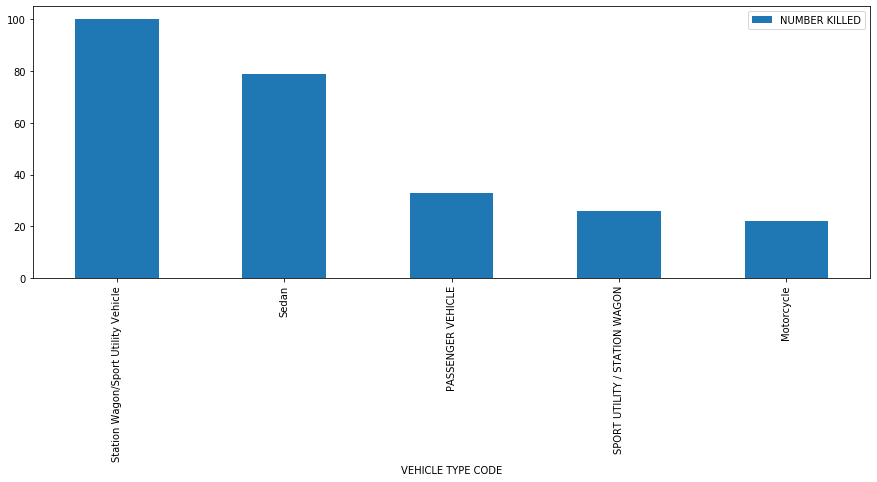

In [15]:
# Code here
top_killed_vhtype_df = all_killed_vhtype_df.head(5)

fig, ax = plt.subplots(figsize=(15,5))
top_killed_vhtype_df.plot.bar(ax=ax)

**Type your answer to the question in this cell**